<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/try_Best_DenseNet121_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU**

In [1]:
!nvidia-smi

Fri May 22 15:22:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# **Import Libraries**

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight, compute_class_weight

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

import shutil
import os
from os.path import join

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

# **Clone Data**

In [4]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

fatal: destination path 'ham10000-with-one-image-folder' already exists and is not an empty directory.


# **Constant Variables**

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# **Prepare Data**

In [0]:
input_path = '/content/ham10000-with-one-image-folder'
metadata_path = os.path.join(input_path, 'HAM10000_metadata.csv')
all_img_path = os.path.join(input_path, 'HAM1000_images')

In [7]:
print(metadata_path)
print(all_img_path)

/content/ham10000-with-one-image-folder/HAM10000_metadata.csv
/content/ham10000-with-one-image-folder/HAM1000_images


In [0]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
data = pd.read_csv(metadata_path)
num_examples = data.values.shape[0]
inputs = np.empty(shape=(num_examples, IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.float32)
labels = np.empty(shape=(num_examples), dtype=np.uint8)

for i, row in enumerate(data.values):
    img_id = row[1]
    label = row[2]
    im_path = ''
    im_path = os.path.join(all_img_path, img_id) + '.jpg'
    if (os.path.isfile(all_img_path)):
        im_path = all_img_path
    # else:
    #     raise Exception ('File not found \'%s\'' %img_id)
    img = Image.open(im_path).resize((IMG_WIDTH, IMG_HEIGHT), Image.LANCZOS)
    inputs[i] = np.array(img)/255.0
    labels[i] = label_names.index(label)

### **Split Data**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1, random_state=555)

del inputs
del labels

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=555)

In [10]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(6309, 224, 224, 3) (6309,)
(2704, 224, 224, 3) (2704,)
(1002, 224, 224, 3) (1002,)


### **Data Augmentation**

In [0]:
datagen = ImageDataGenerator(rotation_range=360,  
                             zoom_range = 0.3,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')

In [0]:
datagen.fit(x_train)

# **Focal Loss**

https://github.com/mkocabas/focal-loss-keras






$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [0]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

# **Build Model**

### **Use DenseNet121 + fine tuning**

In [0]:
def build_model():
  base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(dropout_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
  
  model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [15]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### **Architecture**

In [0]:
# model.summary()

### **Callbacks**

In [0]:
model_path = '/content/Best_DenseNet121_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_plateau = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.00001)

In [0]:
cb_list = [checkpoint, early_stop, reduce_plateau]

### **Training**

In [22]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_val, y_val, compute_sample_weight('balanced', y_val)),
                              class_weight=compute_class_weight('balanced', np.unique(y_train), y_train),
                              steps_per_epoch=math.ceil(x_train.shape[0]/BATCH_SIZE),
                              epochs=EPOCHS,
                              callbacks=cb_list)

Epoch 1/100
2704/198 [=========================================================================================================================================================================================================================================================================================================================================================================================================================] - 8s 3ms/sample - loss: 2.2207 - acc: 0.5288

Epoch 00001: val_loss improved from -inf to 1.99749, saving model to /content/Best_DenseNet121_model.h5
198/198 [==============================] - 158s 798ms/step - loss: 2.1160 - acc: 0.3059 - val_loss: 1.9975 - val_acc: 0.5288
Epoch 2/100
2704/198 [==============================================================================================================================================================================================================================================================================

In [0]:
model.save_weights('/content/Best_DenseNet121_weights.h5')

# **Accuracy and Loss Graph**

### **Accuracy**

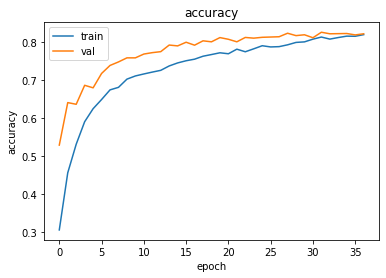

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### **Loss**

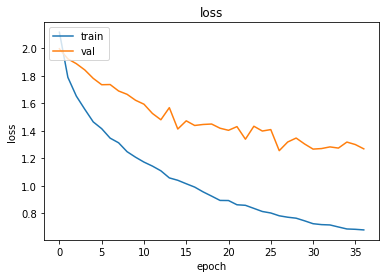

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [0]:
test_model = load_model

In [44]:
y_pred = np.argmax(model.predict(x_test), axis=1)
print('balanced acc on test set:', balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

balanced acc on test set: 0.5366423234296459


### **Classification Report**

In [48]:
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=label_names)
print(report)

              precision    recall  f1-score   support

       akiec       0.58      0.21      0.31        33
         bcc       0.67      0.68      0.67        41
         bkl       0.55      0.55      0.55        99
          df       1.00      0.08      0.14        13
         mel       0.62      0.52      0.56       118
          nv       0.89      0.96      0.92       681
        vasc       0.93      0.76      0.84        17

    accuracy                           0.81      1002
   macro avg       0.75      0.54      0.57      1002
weighted avg       0.80      0.81      0.80      1002



### **Confusion Matrix**

Confusion matrix, without normalization
[[  7   5  11   0   6   4   0]
 [  0  28   3   0   3   6   1]
 [  1   6  54   0  11  27   0]
 [  0   1   3   1   2   6   0]
 [  4   1  12   0  61  40   0]
 [  0   0  16   0  13 652   0]
 [  0   1   0   0   2   1  13]]


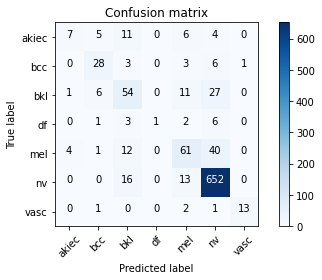

In [52]:
cm = (confusion_matrix(y_true=y_test, y_pred=y_pred))

plot_confusion_matrix(cm, label_names)

### **Sensitivity & Specificity**

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [54]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.5833
specificity: 1.0000


# **Grad-CAM**

In [0]:
last_conv2d = 'conv5_block16_2_conv'

### **AKIEC**

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.864
	nv             	(5)	with probability 0.054
	akiec          	(0)	with probability 0.027
	df             	(3)	with probability 0.023
	bcc            	(1)	with probability 0.012
Explanation for 'mel'


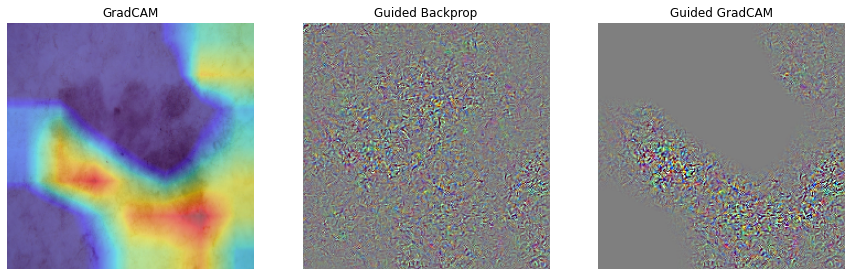

In [57]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

### **BCC**

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	nv             	(5)	with probability 0.782
	mel            	(4)	with probability 0.113
	bkl            	(2)	with probability 0.035
	bcc            	(1)	with probability 0.027
	df             	(3)	with probability 0.018
Explanation for 'nv'


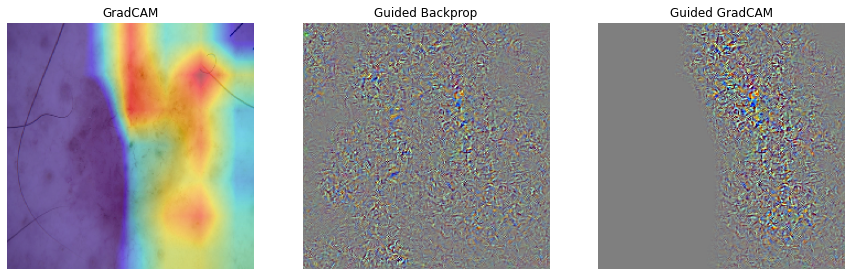

In [59]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

### **BKL**

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.542
	bkl            	(2)	with probability 0.221
	nv             	(5)	with probability 0.149
	df             	(3)	with probability 0.036
	vasc           	(6)	with probability 0.028
Explanation for 'mel'


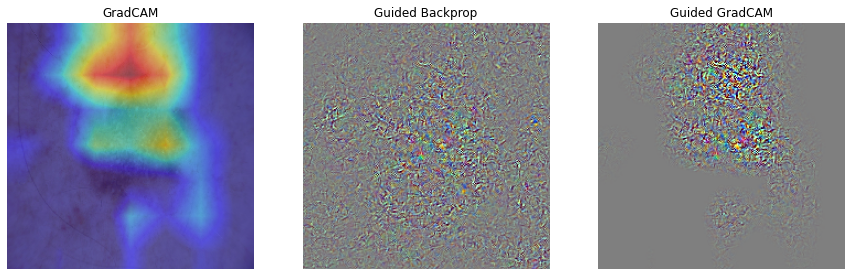

In [61]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

### **DF**

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	nv             	(5)	with probability 0.831
	df             	(3)	with probability 0.047
	vasc           	(6)	with probability 0.036
	mel            	(4)	with probability 0.034
	bkl            	(2)	with probability 0.033
Explanation for 'nv'


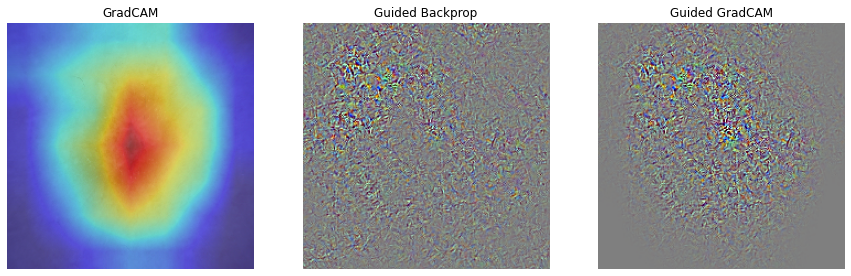

In [63]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

### **MEL**

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.526
	nv             	(5)	with probability 0.313
	bkl            	(2)	with probability 0.059
	akiec          	(0)	with probability 0.037
	df             	(3)	with probability 0.028
Explanation for 'mel'


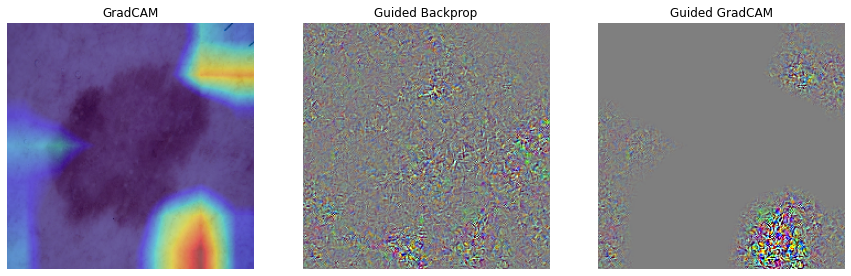

In [65]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

### **NV**

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	nv             	(5)	with probability 0.642
	mel            	(4)	with probability 0.122
	vasc           	(6)	with probability 0.067
	df             	(3)	with probability 0.066
	bkl            	(2)	with probability 0.052
Explanation for 'nv'


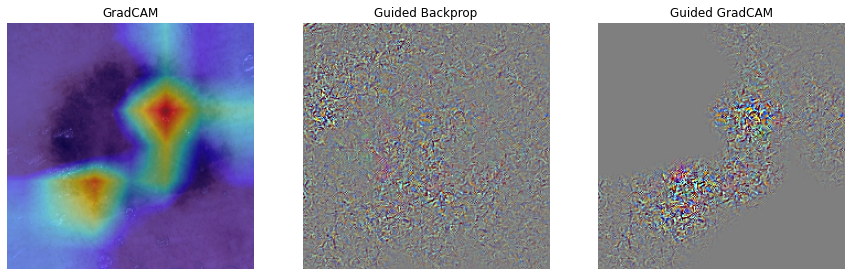

In [67]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

### **VASC**

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	vasc           	(6)	with probability 0.763
	nv             	(5)	with probability 0.173
	df             	(3)	with probability 0.033
	bcc            	(1)	with probability 0.021
	akiec          	(0)	with probability 0.005
Explanation for 'vasc'


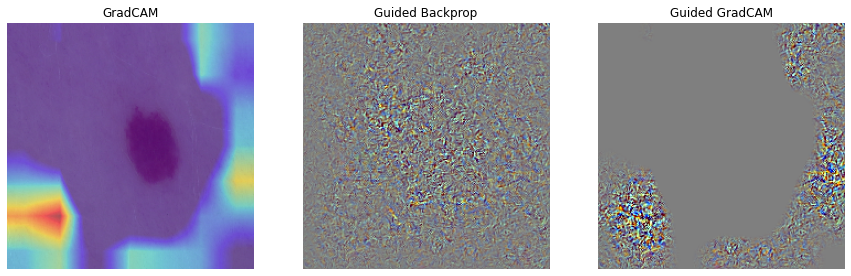

In [69]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# **Download Model**

In [0]:
from google.colab import files

In [71]:
files.download('/content/CW_Focal-Loss_ResNet50_model.h5')
files.download('/content/CW_Focal-Loss_ResNet50_weights.h5')

FileNotFoundError: ignored